(0.0, 20.0)

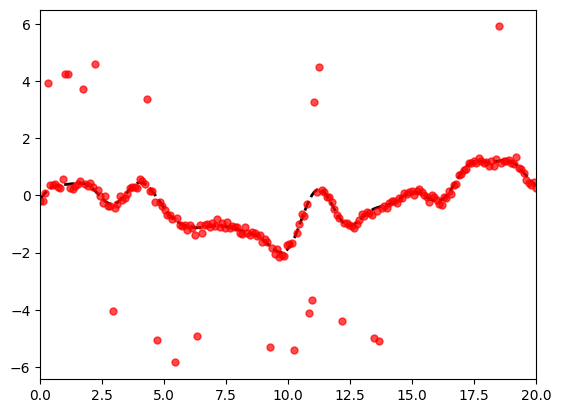

In [1]:
from typing import Optional

import tensorflow as tf
import numpy as np
#from Cython.Utility.CConvert import length
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random

from tensorflow.python.keras.engine.training_utils_v1 import check_num_samples

import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 200
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [2]:
import numpy as np
np.exp(-2)-(np.exp(-1)+np.exp(-2)+np.exp(-3))/3

-0.048998647688693636

In [3]:

standard_gp = gpflow.models.SVGP(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)

TypeError: Error calling wrapped function (see above error). If you believe your parameters actually are correct, the error can sometimes be fixed by setting `tf_decorator=True` on your `@check_shapes` decorator.

NameError: name 'f_mean' is not defined

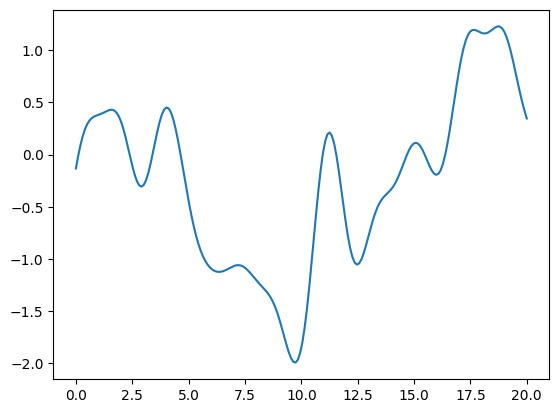

In [8]:
plt.plot(x,f)
plt.plot(x,f_mean)
plt.legend()

In [9]:

def update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w,K_u_x,K_uu_inv):
    sum_K_j=sigma_2**(-2)*J_w_inv[0,0]*tf.matmul(K_u_x[:,0:1],tf.transpose(K_u_x[:,0:1]))
    for i in range(1,len(J_w_inv)):
        sum_K_j+=sigma_2**(-2)*J_w_inv[i,i]*tf.matmul(K_u_x[:,i:(i+1)],tf.transpose(K_u_x[:,i:(i+1)]))
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + tf.matmul(K_uu_inv,sum_K_j)@K_uu_inv)
    q2 = tf.matmul(( K_uu_inv@K_u_x@J_w_inv/ sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)


def update_Sigma_u(sigma_2, J_w_inv,K_uu_inv,K_u_x):
    """
    Compute the updated value of Sigma_f.

    Parameters:
        c_f (float): Scaling constant.
        K (Tensor): Kernel matrix.
        sigma_2 (float): Noise variance.
        J_w (Tensor): Weight matrix.

    Returns:
        Tensor: The updated value of Sigma_f.
    """
    sum_K_j=sigma_2**(-2)*J_w_inv[0,0]*K_u_x[:,0:1]*tf.transpose(K_u_x[:,0:1])
    for i in range(1,len(J_w_inv)):
        sum_K_j+=sigma_2**(-2)*J_w_inv[i,i]*K_u_x[:,i:(i+1)]*tf.transpose(K_u_x[:,i:(i+1)])
    return  tf.linalg.inv(K_uu_inv*sum_K_j*K_uu_inv+K_uu_inv)


def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)


def Full_sample_estimate(variance, lengthscale,X_u,X,w_full, c_f, alpha, Y):
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2)))

    
    K_uu = kernel.matrix(X_u, X_u)
    K_ux_train= kernel.matrix(X_u, X)
    Sigma_u = update_Sigma_u(sigma**2, J_w_inv,tf.linalg.inv(K_uu),K_ux_train)
    Sigma_u = c_f*Sigma_u
    Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
    Sigma_a_inv = tf.linalg.inv(Sigma_a)
    mu_u =update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y, m_w_full,K_ux_train,tf.linalg.inv(K_uu))
    
    K_star = tf.transpose(kernel.matrix(X, X_u))
    K_star_star = kernel.matrix(X, X)

    mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K_uu) @ mu_u
    sigma_f_pred = K_star_star
    sigma_f_pred = sigma_f_pred - c_f * tf.transpose(K_star) @ tf.linalg.inv(K_uu + sigma ** 2 *tf.linalg.eye(cN,cN,dtype=tf.float64)) @ K_star
    sigma_f_pred = sigma_f_pred + (c_f - 1) * tf.transpose(K_star) @ tf.linalg.inv(K_uu) @ K_star + tf.linalg.eye(200, dtype=tf.float64) * sigma**2
    sigma_f_pred=tf.linalg.diag_part(sigma_f_pred)#*tf.gather(w_full, test_indices)**(-2)
    
    return (mu_f_pred, sigma_f_pred)

    




import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w_full = W.dy(X, y) ** 2

sigma = tf.Variable(1, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c_f = tf.Variable(1., dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))

X_u=tf.constant(tf.range(1,21,1, dtype=tf.float64),shape=[20,1])
cN=20
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


import tensorflow_probability as tfp

for i in range(100):
    print(i)
    #create batch for the iteration
    X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.2, seed=1)
    n_test = X_test.shape[0]
    #estimate Gpflow kernel.
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K_uu = kernel.matrix(X_u, X_u)
    K_ux_train= kernel.matrix(X_u, X_train)
    
    #EXTRACT TRAIN INDEXES I
    new_ind = list(train_indices.numpy())
    #update quantitites, Sigma_a,J_w
    w_train = tf.gather(w_full, train_indices)
    m_w = tf.gather(m_w_full, train_indices)
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, -2)))
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, 2)))

    #UPDATE VARIANCE OF f_u
    Sigma_u = update_Sigma_u(sigma**2, J_w_inv,tf.linalg.inv(K_uu),K_ux_train)
    Sigma_u =c_f*Sigma_u
    Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
    Sigma_a_inv = tf.linalg.inv(Sigma_a)
    
    #UPDATE MEAN OF f_u
    mu_u = update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y_train, m_w,K_ux_train,tf.linalg.inv(K_uu))
    
        
    #KERNEL BETWEEN U AND X_TEST
    with tf.GradientTape(persistent=True) as tape:
        K_star = tf.transpose(kernel.matrix(X_test, X_u))
        K_star_star = kernel.matrix(X_test, X_test)
        
        #PREDICTED MEAN for Y_test
        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K_uu) @ mu_u
        
        #COMPUTE LOSS
        vv =(Y_test-mu_f_pred)
        loss = tf.reduce_mean(tf.square(vv))

       
    grad = tape.gradient(loss, [c_f, sigma, variance, lengthscale, alpha])
    optimizer = tf.optimizers.Adam(learning_rate=0.05)
    optimizer.apply_gradients(zip(grad, [c_f, sigma, variance, lengthscale, alpha]))
Mu_full, Sigma_full1 = Full_sample_estimate(variance, lengthscale,X_u, X, w_full, c_f, alpha, y)


0
1


/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['Variable:0', 'Variable:0', 'Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


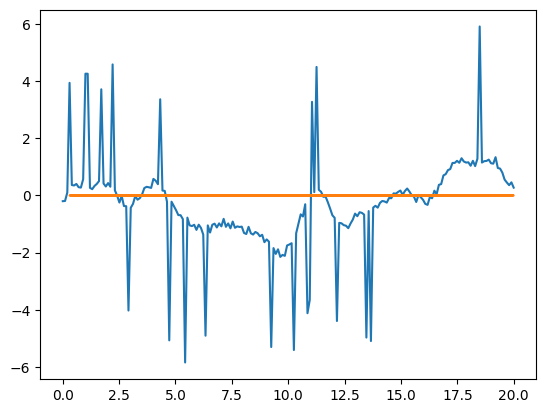

In [11]:
plt.plot(x,y)
plt.plot(X_test,mu_f_pred)

In [4]:

def update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w,K_u_x,K_uu_inv):
    sum_K_j=sigma_2**(-2)*J_w_inv[0,0]*tf.matmul(K_u_x[:,0:1],tf.transpose(K_u_x[:,0:1]))
    for i in range(1,len(J_w_inv)):
        sum_K_j+=sigma_2**(-2)*J_w_inv[i,i]*tf.matmul(K_u_x[:,i:(i+1)],tf.transpose(K_u_x[:,i:(i+1)]))
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + tf.matmul(K_uu_inv,sum_K_j)@K_uu_inv)
    q2 = tf.matmul(( K_uu_inv@K_u_x@J_w_inv/ sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)

import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w = W.dy(X, y) ** 2

cN=30
X_u=tf.constant(tf.range(1,21,20/cN, dtype=tf.float64),shape=[cN,1])
print(X_u.shape)


sigma = tf.Variable(1., dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
sigma_u = tf.Variable([1.]*cN, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))

Sigma_u=tf.linalg.diag(sigma_u)
#UPDATE VARIANCE OF f_u
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
K_uu = kernel.matrix(X_u, X_u)
Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
Sigma_a_inv = tf.linalg.inv(Sigma_a)
K_ux= kernel.matrix(X_u, X)

def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


import tensorflow_probability as tfp

for i in range(100):
    print(i)
    #estimate Gpflow kernel.
    #update quantitites, Sigma_a,J_w
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2)))
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2)))
    
    #UPDATE MEAN OF f_u
    mu_u = update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, y, m_w,K_ux,tf.linalg.inv(K_uu))
    
   
    #KERNEL BETWEEN U AND X_TEST
    with tf.GradientTape(persistent=True) as tape:
        
        Sigma_u=tf.linalg.diag(sigma_u)
        #UPDATE VARIANCE OF f_u
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K_uu = kernel.matrix(X_u, X_u)
        K_ux= kernel.matrix(X_u, X)
        K_xu=tf.transpose(K_ux)
        
        Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a)
        K = kernel.matrix(X, X)
        K_uu_inv=tf.linalg.inv(K_uu)
        #PREDICTED MEAN for Y_test
        mu_f_pred = K_xu @ K_uu_inv @ mu_u
        loss1=tf.linalg.trace(0.5*sigma**(-2)*Sigma_u@K_uu_inv@K_ux@J_w_inv@K_xu@K_uu_inv)
        loss1+=-0.5/(alpha-1)*tf.math.log(tf.linalg.det(Sigma_a)/(tf.linalg.det(Sigma_u)**(1-alpha)*tf.linalg.det(K_uu)**(alpha)))
        loss1+=tf.reduce_sum(0.5*sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@mu_f_pred)-tf.reduce_sum(sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@y)+alpha*0.5*tf.reduce_sum(tf.transpose(mu_u)@Sigma_a_inv@mu_u)
        
        #COMPUTE LOSS
        #loss=tf.reduce_sum(0.5*sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@mu_f_pred)+tf.linalg.trace(0.5*sigma**(-2)*J_w_inv@(K-K_xu@K_uu_inv@K_ux))-tf.reduce_sum(sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@y)+alpha*0.5*tf.reduce_sum(tf.transpose(mu_u)@Sigma_a_inv@mu_u)-0.5/(alpha-1)*tf.math.log(tf.linalg.det(Sigma_a)/(tf.linalg.det(Sigma_u)**(1-alpha)*tf.linalg.det(K_uu)**(alpha)))
        #loss+=tf.linalg.trace(0.5*sigma**(-2)*Sigma_u@K_uu_inv@K_ux@J_w_inv@K_xu@K_uu_inv)
        loss=tf.reduce_mean(tf.square(y-mu_f_pred))
       
    grad = tape.gradient(loss1, [sigma_u,variance,lengthscale])
    optimizer = tf.optimizers.Adam(learning_rate=0.05)
    optimizer.apply_gradients(zip(grad, [sigma_u,variance,lengthscale]))

    #grad = tape.gradient(loss, [ variance, lengthscale, alpha])
   # optimizer = tf.optimizers.Adam(learning_rate=0.05)
    #optimizer.apply_gradients(zip(grad, [ variance, lengthscale, alpha]))



(30, 1)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [5]:
sigma

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>

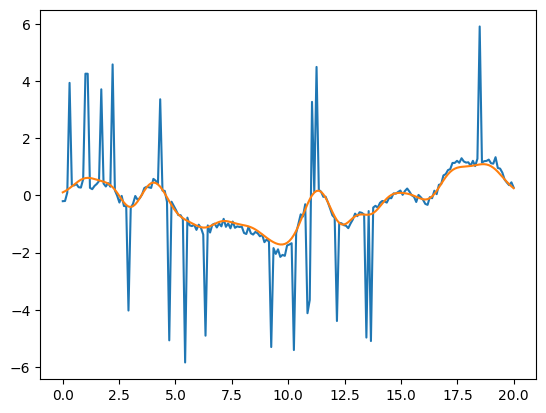

In [6]:
plt.plot(x,y)
plt.plot(X,mu_f_pred)
mu_f_pred_old=mu_f_pred
#plt.plot(x,Mu_full)

In [13]:

def update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w,K_u_x,K_uu_inv):
    sum_K_j=sigma_2**(-2)*J_w_inv[0,0]*tf.matmul(K_u_x[:,0:1],tf.transpose(K_u_x[:,0:1]))
    for i in range(1,len(J_w_inv)):
        sum_K_j+=sigma_2**(-2)*J_w_inv[i,i]*tf.matmul(K_u_x[:,i:(i+1)],tf.transpose(K_u_x[:,i:(i+1)]))
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + tf.matmul(K_uu_inv,sum_K_j)@K_uu_inv)
    q2 = tf.matmul(( K_uu_inv@K_u_x@J_w_inv/ sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)

import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w = W.dy(X, y) ** 2

cN=30
X_u=tf.constant(tf.range(1,21,20/cN, dtype=tf.float64),shape=[cN,1])
print(X_u.shape)
n=X.shape[0]


sigma=tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
sigma_u = tf.Variable([1.]*cN, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))

Sigma_u=tf.linalg.diag(sigma_u)
#UPDATE VARIANCE OF f_u
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
K_uu = kernel.matrix(X_u, X_u)
Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
Sigma_a_inv = tf.linalg.inv(Sigma_a)
K_ux= kernel.matrix(X_u, X)

def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


import tensorflow_probability as tfp

for i in range(1000):
    print(i)
    #estimate Gpflow kernel.
    #update quantitites, Sigma_a,J_w
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2)))
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2)))
    
    #UPDATE MEAN OF f_u
    mu_u = update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, y, m_w,K_ux,tf.linalg.inv(K_uu))
    
   
    #KERNEL BETWEEN U AND X_TEST
    with tf.GradientTape(persistent=True) as tape:
        
        Sigma_u=tf.linalg.diag(sigma_u)
        #UPDATE VARIANCE OF f_u
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K_uu = kernel.matrix(X_u, X_u)
        K_ux= kernel.matrix(X_u, X)
        K_xu=tf.transpose(K_ux)
        
        Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a)
        K = kernel.matrix(X, X)
        K_uu_inv=tf.linalg.inv(K_uu)
        #PREDICTED MEAN for Y_test
        mu_f_pred = K_xu @ K_uu_inv @ mu_u
        quant_1=Sigma_u@K_uu_inv@K_ux@J_w_inv@K_xu@K_uu_inv
        loss1=tf.linalg.trace(0.5*sigma**(-2)*quant_1)
        loss1+=-0.5/(alpha-1)*tf.math.log(tf.linalg.det(Sigma_a)/(tf.linalg.det(Sigma_u)**(1-alpha)*tf.linalg.det(K_uu)**(alpha)))
        loss1+=tf.reduce_sum(0.5*sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@mu_f_pred)-tf.reduce_sum(sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@y)+alpha*0.5*tf.reduce_sum(tf.transpose(mu_u)@Sigma_a_inv@mu_u)
        loss1+=tf.linalg.trace(0.5*sigma**(-2)*J_w_inv@(K-K_xu@K_uu_inv@K_ux))
        

    grad = tape.gradient(loss1, [sigma_u,variance,lengthscale])
    optimizer = tf.optimizers.Adam(learning_rate=0.05)
    optimizer.apply_gradients(zip(grad, [sigma_u,variance,lengthscale]))
    sigma=tf.sqrt(tf.transpose(mu_f_pred)@J_w_inv@(mu_f_pred)/tf.reduce_sum(J_w_inv))
    #grad = tape.gradient(loss, [ variance, lengthscale, alpha])
   # optimizer = tf.optimizers.Adam(learning_rate=0.05)
    #optimizer.apply_gradients(zip(grad, [ variance, lengthscale, alpha]))



(30, 1)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

In [14]:
sigma

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5.59050221]])>

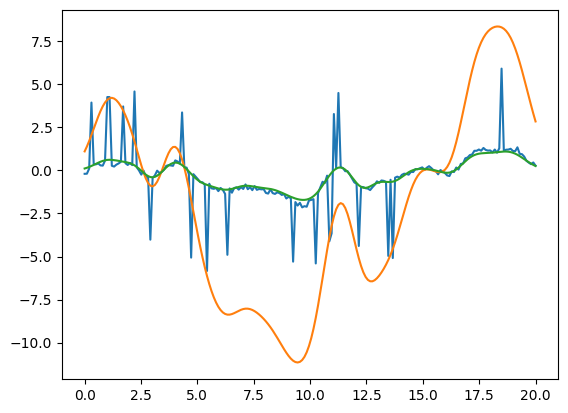

In [15]:
plt.plot(x,y)
plt.plot(X,mu_f_pred)
plt.plot(X,mu_f_pred_old)

In [69]:
sigma

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.7604723]])>

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.76047019]])>

In [45]:

def update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w,K_u_x,K_uu_inv):
    sum_K_j=sigma_2**(-2)*J_w_inv[0,0]*tf.matmul(K_u_x[:,0:1],tf.transpose(K_u_x[:,0:1]))
    for i in range(1,len(J_w_inv)):
        sum_K_j+=sigma_2**(-2)*J_w_inv[i,i]*tf.matmul(K_u_x[:,i:(i+1)],tf.transpose(K_u_x[:,i:(i+1)]))
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + tf.matmul(K_uu_inv,sum_K_j)@K_uu_inv)
    q2 = tf.matmul(( K_uu_inv@K_u_x@J_w_inv/ sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)

import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w = W.dy(X, y) ** 2

cN=60
X_u=tf.constant(tf.range(1,21,20/cN, dtype=tf.float64),shape=[cN,1])
print(X_u.shape)
n=X.shape[0]


sigma=tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
sigma_u = tf.Variable([1.]*cN, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))
x_u=tf.Variable(tf.range(1,21,20/cN, dtype=tf.float64),shape=[cN])

Sigma_u=tf.linalg.diag(sigma_u)
#UPDATE VARIANCE OF f_u
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
K_uu = kernel.matrix(X_u, X_u)
Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
Sigma_a_inv = tf.linalg.inv(Sigma_a)
K_ux= kernel.matrix(X_u, X)

def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


import tensorflow_probability as tfp

for i in range(100):
    print(i)
    #estimate Gpflow kernel.
    #update quantitites, Sigma_a,J_w
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2)))
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2)))
    
    #UPDATE MEAN OF f_u
    mu_u = update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, y, m_w,K_ux,tf.linalg.inv(K_uu))
    
   
    #KERNEL BETWEEN U AND X_TEST
    with tf.GradientTape(persistent=True) as tape:
        
        Sigma_u=tf.linalg.diag(sigma_u)
        #UPDATE VARIANCE OF f_u
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        X_u=tf.reshape(x_u,[-1,1])
        K_uu = kernel.matrix(X_u, X_u)
        K_ux= kernel.matrix(X_u, X)
        K_xu=tf.transpose(K_ux)
        
        Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a)
        K = kernel.matrix(X, X)
        K_uu_inv=tf.linalg.inv(K_uu)
        #PREDICTED MEAN for Y_test
        mu_f_pred = K_xu @ K_uu_inv @ mu_u
        loss1=tf.linalg.trace(0.5*sigma**(-2)*Sigma_u@K_uu_inv@K_ux@J_w_inv@K_xu@K_uu_inv)
        loss1+=-0.5/(alpha-1)*tf.math.log(tf.linalg.det(Sigma_a)/(tf.linalg.det(Sigma_u)**(1-alpha)*tf.linalg.det(K_uu)**(alpha)))
        loss1+=tf.reduce_sum(0.5*sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@mu_f_pred)-tf.reduce_sum(sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@y)+alpha*0.5*tf.reduce_sum(tf.transpose(mu_u)@Sigma_a_inv@mu_u)
        loss1+=tf.linalg.trace(0.5*sigma**(-2)*J_w_inv@(K-K_xu@K_uu_inv@K_ux))
        

    grad = tape.gradient(loss1, [sigma_u,variance,lengthscale,x_u])
    optimizer = tf.optimizers.Adam(learning_rate=0.05)
    optimizer.apply_gradients(zip(grad, [sigma_u,variance,lengthscale,x_u]))
    #SUBSTITUTE WITH MARGINAL.
    sigma=tf.transpose(y-mu_f_pred-m_w)@(y-mu_f_pred-m_w)/n
    sigma=tf.sqrt(sigma)



(60, 1)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


NameError: name 'mu_f_pred_old' is not defined

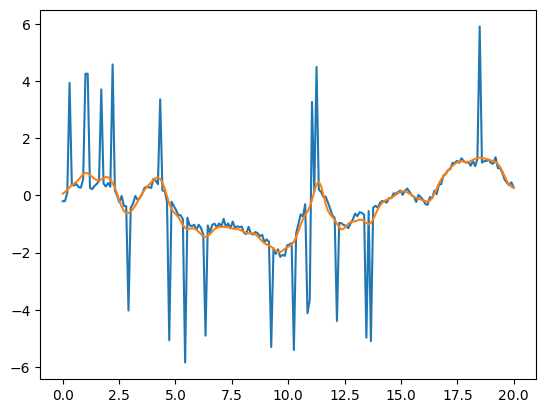

In [47]:
plt.plot(x,y)
plt.plot(X,mu_f_pred)
plt.plot(X,mu_f_pred_old)

In [48]:
sigma

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.20333348]])>

In [49]:

def update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w,K_u_x,K_uu_inv):
    sum_K_j=sigma_2**(-2)*J_w_inv[0,0]*tf.matmul(K_u_x[:,0:1],tf.transpose(K_u_x[:,0:1]))
    for i in range(1,len(J_w_inv)):
        sum_K_j+=sigma_2**(-2)*J_w_inv[i,i]*tf.matmul(K_u_x[:,i:(i+1)],tf.transpose(K_u_x[:,i:(i+1)]))
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + tf.matmul(K_uu_inv,sum_K_j)@K_uu_inv)
    q2 = tf.matmul(( K_uu_inv@K_u_x@J_w_inv/ sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)

import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w = W.dy(X, y) ** 2

cN=60
X_u=tf.constant(tf.range(1,21,20/cN, dtype=tf.float64),shape=[cN,1])
print(X_u.shape)
n=X.shape[0]


sigma=tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))
x_u=tf.Variable(tf.range(1,21,20/cN, dtype=tf.float64),shape=[cN])

Sigma_u=tf.linalg.diag(sigma_u)
#UPDATE VARIANCE OF f_u
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
X_u=tf.reshape(x_u,[-1,1])
K_uu = kernel.matrix(X_u, X_u)
K_ux= kernel.matrix(X_u, X)
K_xu=tf.transpose(K_ux)
K_uu_inv=tf.linalg.inv(K_uu) 
Sigma_u=K_xu@K_uu_inv@K_ux
Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u #size probl
Sigma_a_inv = tf.linalg.inv(Sigma_a)

def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


import tensorflow_probability as tfp

for i in range(100):
    print(i)
    #estimate Gpflow kernel.
    #update quantitites, Sigma_a,J_w
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2)))
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2)))
    
    #UPDATE MEAN OF f_u
    mu_u = update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, y, m_w,K_ux,tf.linalg.inv(K_uu))
    
   
    #KERNEL BETWEEN U AND X_TEST
    with tf.GradientTape(persistent=True) as tape:
        

        #UPDATE VARIANCE OF f_u
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        X_u=tf.reshape(x_u,[-1,1])
        K_uu = kernel.matrix(X_u, X_u)
        K_ux= kernel.matrix(X_u, X)
        K_xu=tf.transpose(K_ux)
        K_uu_inv=tf.linalg.inv(K_uu) 
        Sigma_u=K_xu@K_uu_inv@K_ux
        Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a)
        K = kernel.matrix(X, X)
       #PREDICTED MEAN for Y_test
        mu_f_pred = K_xu @ K_uu_inv @ mu_u
        loss1=tf.linalg.trace(0.5*sigma**(-2)*Sigma_u@K_uu_inv@K_ux@J_w_inv@K_xu@K_uu_inv)
        loss1+=-0.5/(alpha-1)*tf.math.log(tf.linalg.det(Sigma_a)/(tf.linalg.det(Sigma_u)**(1-alpha)*tf.linalg.det(K_uu)**(alpha)))
        loss1+=tf.reduce_sum(0.5*sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@mu_f_pred)-tf.reduce_sum(sigma**(-2)*tf.transpose(mu_f_pred)@J_w_inv@y)+alpha*0.5*tf.reduce_sum(tf.transpose(mu_u)@Sigma_a_inv@mu_u)
        loss1+=tf.linalg.trace(0.5*sigma**(-2)*J_w_inv@(K-K_xu@K_uu_inv@K_ux))
        

    grad = tape.gradient(loss1, [variance,lengthscale,x_u])
    optimizer = tf.optimizers.Adam(learning_rate=0.05)
    optimizer.apply_gradients(zip(grad, [variance,lengthscale,x_u]))
    #SUBSTITUTE WITH MARGINAL.
    sigma=tf.transpose(y-mu_f_pred-m_w)@(y-mu_f_pred-m_w)/n
    sigma=tf.sqrt(sigma)



(60, 1)


2025-04-10 22:10:18.108880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [60,60] vs. [200,200]


InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [60,60] vs. [200,200] [Op:AddV2] name: 